In [ ]:
import copy
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector

from keras.layers import TimeDistributed
from numpy import hstack
from sklearn.preprocessing import StandardScaler
import datetime
import time
import joblib
from datetime import timedelta, date
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import os
import seaborn as sns; sns.set_theme()
import errno
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.models import load_model
import pickle
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from collections import Counter
import imblearn
import collections
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from matplotlib import pyplot

In [ ]:
import pandas as pd

def load_data_south_indian(url):
    """
    Load and preprocess data for South Indian region.

    Parameters:
    - url (str): URL or file path to the CSV file.

    Returns:
    - pd.DataFrame: Processed DataFrame with a 'category' column.
    """
    # Load data from CSV
    df = pd.read_csv(url)

    # Add a 'category' column based on speed ranges
    df['category'] = df['Speed(knots)'].apply(lambda x:
        0 if x <= 33 else
        1 if 34 <= x <= 47 else
        2 if 48 <= x <= 63 else
        3 if 64 <= x <= 89 else
        4 if 90 <= x <= 115 else
        5
        )

    return df

def load_data_south_pacific(url):
    """
    Load and preprocess data for South Pacific region.

    Parameters:
    - url (str): URL or file path to the CSV file.

    Returns:
    - pd.DataFrame: Processed DataFrame with a 'category' column.
    """
    # Load data from CSV
    df = pd.read_csv(url)

    # Add a 'category' column based on speed ranges
    df['category'] = df['Speed(knots)'].apply(lambda x:
        0 if x <= 33 else
        1 if 34 <= x <= 47 else
        2 if 48 <= x <= 63 else
        3 if 64 <= x <= 85 else
        4 if 86 <= x <= 107 else
        5
    )
    return df

In [ ]:
ocean = 'south_pacific'

# Display the selected ocean
print(f"Selected ocean: {ocean}")

# Set the data URL and function based on the selected ocean
if ocean == 'south_indian':
    url_data = 'https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_indian_hurricane.csv'
    data_loading_function = load_data_south_indian
    hot_encoded_result_file_name = 'south_indian'
    category_result_file_name = 'roc_data_south_indian'
else:
    url_data = 'https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_pacific_hurricane.csv'
    data_loading_function = load_data_south_pacific
    hot_encoded_result_file_name = 'south_pacific'
    category_result_file_name = 'roc_data_south_pacific'

# Display the data URL for verification
print(f"Data URL: {url_data}")

# Display the result file names
print(f"Hot-encoded result file name: {hot_encoded_result_file_name}")
print(f"Category result file name: {category_result_file_name}")


Selected ocean: south_pacific
Data URL: https://raw.githubusercontent.com/sydney-machine-learning/cyclonedatasets/main/SouthIndian-SouthPacific-Ocean/South_pacific_hurricane.csv
Hot-encoded result file name: south_pacific
Category result file name: roc_data_south_pacific


In [ ]:
# Load data using the specified function and URL
df = data_loading_function(url_data)

# Latitude and longitude values into int
df['Lat'] = df['Lat'].apply(lambda x: -int(x[:-1]) * 0.1 if x.endswith('N') else int(x[:-1]) * 0.1 if x.endswith('S') else 0)
df['Lon'] = df['Lon'].apply(lambda x: -int(x[:-1]) * 0.1 if x.endswith('W') else int(x[:-1]) * 0.1 if x.endswith('E') else 0)

# Extract 'Speed(knots)' and 'category' columns as lists
speed = df['Speed(knots)'].tolist()
categories = df['category'].tolist()
latitude = df['Lat'].tolist()
longitude = df['Lon'].tolist()


# Display the first few rows of the DataFrame
df_head = df.head()
print("DataFrame Head:")
print(df_head)

DataFrame Head:
  Basin  No. of Cycl        Time     V5  V6   Lat    Lon  Speed(knots)  \
0    SP           14  1982012518   BEST   0  18.0  154.1            25   
1    SP           14  1982012600   BEST   0  19.1  154.8            25   
2    SP           14  1982012606   BEST   0  19.7  155.7            25   
3    SP           14  1982012612   BEST   0  19.9  156.7            30   
4    SP           14  1982012618   BEST   0  20.1  157.8            35   

   lat_tenth  lon_tenth  category  
0       18.0      154.1         0  
1       19.1      154.8         0  
2       19.7      155.7         0  
3       19.9      156.7         0  
4       20.1      157.8         1  


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def split_sequence(sequences, n_steps_in, n_steps_out):
    """
    Split multivariate sequences into input and output parts.

    Parameters:
    - sequences (numpy.ndarray): Multivariate time series data.
    - n_steps_in (int): Number of input time steps.
    - n_steps_out (int): Number of output time steps.

    Returns:
    - tuple: Input sequences (X) and output sequences (y) as numpy arrays.
    """
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return X, y

def uni_split_sequence(sequence, n_steps):
    """
    Split univariate sequence into input and output parts.

    Parameters:
    - sequence (list): Univariate time series data.
    - n_steps (int): Number of input time steps.

    Returns:
    - tuple: Input sequences (X) and output sequences (y) as numpy arrays.
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return X , y


def multivariate_split_sequence(sequence, n_steps):
    """
    Split multivariate sequence into input and output parts.

    Parameters:
    - sequence (numpy.ndarray): Multivariate time series data.
    - n_steps (int): Number of input time steps.

    Returns:
    - tuple: Input sequences (X) and output sequences (y) as numpy arrays.
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return X, y

# Example usage:
# Assuming df is your DataFrame with 'Latitude', 'Longitude', 'Speed(knots)', and 'category' columns
features_columns = ['Lat', 'Lon', 'Speed(knots)']
target_column = 'category'

# Extract features and target
features = df[features_columns].values
target = df[target_column].values

n_steps = 5  # Number of input time steps

X, y = multivariate_split_sequence(features, n_steps)

# Now X contains sequences of 'Latitude', 'Longitude', and 'Speed(knots)' for each time step,
# and y contains the corresponding 'category' values.

def rmse(pred, actual):
    """
    Calculate the Root Mean Squared Error (RMSE) between two arrays.

    Parameters:
    - pred (numpy.ndarray): Predicted values.
    - actual (numpy.ndarray): Actual values.

    Returns:
    - float: Root Mean Squared Error.
    """
    return np.sqrt(((pred - actual) ** 2).mean())
def categorical(pred, actual):
    """
    Compute classification metrics for categorical values.

    Parameters:
    - pred (numpy.ndarray): Predicted categorical values.
    - actual (numpy.ndarray): Actual categorical values.

    Returns:
    - tuple: Accuracy, AUC, Confusion Matrix, Precision, Recall, F1 Score.
    """
    cm = confusion_matrix(pred, actual)
    acc = accuracy_score(actual, pred, normalize=True, sample_weight=None)
    ps1 = precision_score(pred, actual, average='micro')
    rs1 = recall_score(pred, actual, average='micro')
    f11 = f1_score(pred, actual, average='micro')
    auc = roc_auc_score(actual, pred)
    return acc, auc, cm, ps1, rs1, f11
def make_confusion_matrix_chart(cf_matrix_test, cmap='Blues', annot_kws=None):
    """
    Generate and display a heatmap-style confusion matrix chart.

    Parameters:
    - cf_matrix_test (numpy.ndarray): Confusion matrix.
    - cmap (str): Colormap for the heatmap.
    - annot_kws (dict): Additional keyword arguments for annotation customization.

    Returns:
    - None
    """
    # Set up the figure and axes
    plt.figure(figsize=(12, 6))

    # Customize the heatmap using seaborn
    sns.heatmap(cf_matrix_test, annot=True, cmap=cmap,
                yticklabels=['0', '1'], xticklabels=['0', '1'],
                fmt='g', annot_kws=annot_kws)

    # Customize axis labels and title
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title('Confusion Matrix - Test Data')

    return None

In [ ]:
# Define whether it's a univariate or multivariate case
univariate_1 = False  # If True, it's a multivariate case

# Define sequence and time step parameters
n_steps_in_1 = 8 # Adjust based on the number of time steps you want to consider for input
n_seq_1= 2  # Adjust based on your specific needs
n_steps_out_1 = 1  # Number of output time steps

# Define the number of features for input and output
n_features_in_1 = 2  # Latitude, Longitude
n_features_out_1 = 2  # 'category'

# Define whether it's a univariate or multivariate case
univariate_2 = True  # If not True, it's a multivariate case

# Define sequence and time step parameters
n_steps_in_2  = 8  # Adjust based on the number of time steps you want to consider for input
n_seq_2 = 2  # Adjust based on your specific needs
n_steps_out_2 = 1  # Number of output time steps

# Define the number of features for input and output
n_features_in_2 = 1  # Latitude, Longitude, Speed
n_features_out_2 = 2  # 'category'
# Define the number of hidden layers in the model
hidden_layers = 50

# Define training parameters
epochs = 100
No_exp = 30 # Number of experiments




In [ ]:
# Initialize variables
cyclone_id = df['No. of Cycl'][0]
X = []
Y = []
start_index = 0
end_index = 0

# Iterate through the DataFrame
for i in range(1, df.shape[0]):
    # Check if the cyclone ID is the same as the previous row
    if df['No. of Cycl'][i] == cyclone_id:
        end_index += 1
    else:
        # Split the sequence and append to X and Y
        x, y = multivariate_split_sequence(features[start_index:end_index + 1, :], n_steps_in_1)
        X.append(x)
        Y.append(y)

        # Update start and end indices for the new cyclone
        cyclone_id = df['No. of Cycl'][i]
        start_index = i
        end_index = i
# Check if it's the last row of the DataFrame
    if i == df.shape[0] - 1:
        # Split the sequence and append to X and Y
        x, y = multivariate_split_sequence(features[start_index:end_index + 1, :], n_steps_in_1)
        X.append(x)
        Y.append(y)


In [ ]:
# Print the initial lengths of X and Y
print(len(X), len(Y))
# Flattening X and Y
X = [item for sublist in X for item in sublist]
Y = [item for sublist in Y for item in sublist]
# Print lengths of X and Y after flattening
print(len(X), len(Y))
print(type(X), Y[0])
print(speed[:10])


391 391
8948 8948
<class 'list'> 40.0
[25, 25, 25, 30, 35, 40, 40, 40, 40, 40]


In [ ]:
for i in range(len(X)):
  X[i] = X[i].tolist()
for i in range(len(X)):
  print(type(X[i]))


<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'li

In [ ]:
# Initialize 'intensify_y' with zeros
intensify_y = [0] * len(X)

# Add labels for rapid intensification
for i in range(len(X)):
    for j in range(len(X[0]) - 4, len(X[0])):
        if (Y[i] - X[i][j][2]) >= 30:
            intensify_y[i] = 1
            break

print(len(intensify_y))

Y = intensify_y


8948


In [ ]:
Xe = X
Ye = Y
print(X[0])


[[18.0, 154.10000000000002, 25.0], [19.1, 154.8, 25.0], [19.700000000000003, 155.70000000000002, 25.0], [19.900000000000002, 156.70000000000002, 30.0], [20.1, 157.8, 35.0], [20.400000000000002, 158.60000000000002, 40.0], [20.700000000000003, 159.10000000000002, 40.0], [21.0, 159.5, 40.0]]


In [ ]:
from collections import Counter

from imblearn.over_sampling import RandomOverSampler
import numpy as np

# Assuming X has shape (samples, time_steps, features)
# Flatten the time steps and features
X1 = np.array(X)
X_flat = np.reshape(X1, (X1.shape[0], -1))

# Check the class distribution before oversampling
print("Class distribution before oversampling:", Counter(Y))

# Create the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Fit and apply the random oversampling on your training data
X_resampled_flat, Y_resampled = X_flat, Y

# Check the class distribution after oversampling
print("Class distribution after oversampling:", Counter(Y_resampled))

# Reshape the oversampled data back to its original shape
X1 = np.reshape(X_resampled_flat, (X_resampled_flat.shape[0], X1.shape[1], X1.shape[2]))
Y = Y_resampled
X = X1.tolist()

Class distribution before oversampling: Counter({0: 8579, 1: 369})
Class distribution after oversampling: Counter({0: 8579, 1: 369})


In [ ]:
print( X[0][0])

[18.0, 154.10000000000002, 25.0]


In [ ]:
for i in range(len(X)):
  for j in range(len(X[i])):
    X[i][j].append(Y[i])
print(X[0][0])

[18.0, 154.10000000000002, 25.0, 0]


In [ ]:
X1 = []
Y1 = []
for i in range(len(X)):
  x = []
  y = []
  for j in range(0,4):
    x.append(X[i][j])
  for k in range(4, 8):
    y.append(X[i][k])
  X1.append(x)
  Y1.append(y)
print(X1[0], Y1[0])

[[18.0, 154.10000000000002, 25.0, 0], [19.1, 154.8, 25.0, 0], [19.700000000000003, 155.70000000000002, 25.0, 0], [19.900000000000002, 156.70000000000002, 30.0, 0]] [[20.1, 157.8, 35.0, 0], [20.400000000000002, 158.60000000000002, 40.0, 0], [20.700000000000003, 159.10000000000002, 40.0, 0], [21.0, 159.5, 40.0, 0]]


In [ ]:
Y2 = []
for i in range(len(Y1)):
  y = []
  for j in range(len(Y1[i])):
    y1 = []
    for k in range(0,3):
      y1.append(Y1[i][j][k])
    y.append(y1)
  Y2.append(y)
print(Y2[0])

[[20.1, 157.8, 35.0], [20.400000000000002, 158.60000000000002, 40.0], [20.700000000000003, 159.10000000000002, 40.0], [21.0, 159.5, 40.0]]


In [ ]:
print(Y2[123])
Y1 = Y2

[[11.8, 156.70000000000002, 25.0], [12.3, 156.8, 30.0], [12.700000000000001, 156.9, 30.0], [13.200000000000001, 157.0, 30.0]]


In [ ]:
print(X1[0])

[[18.0, 154.10000000000002, 25.0, 0], [19.1, 154.8, 25.0, 0], [19.700000000000003, 155.70000000000002, 25.0, 0], [19.900000000000002, 156.70000000000002, 30.0, 0]]


In [ ]:
# Calculate the training limit as 75% of the total length of X
train_limit = int(len(X1) * 0.75)

# Display the calculated training limit
print("Training set size:", train_limit)

Training set size: 6711


In [ ]:
# Extract test data for evaluation
test_X = X1[train_limit + 1:]
test_Y = Y1[train_limit + 1:]
X1 = X1[:train_limit]
Y1 = Y1[:train_limit]
# Display the lengths of the datasets
print("Length of X:", len(X1))
print("Length of Y:", len(Y1))
print("Length of Test X (for evaluation):", len(test_X))
print("Length of Test Y (for evaluation):", len(test_Y))


Length of X: 6711
Length of Y: 6711
Length of Test X (for evaluation): 2236
Length of Test Y (for evaluation): 2236


In [ ]:
test_X1 = []
test_Y1 = []
for i in range(len(test_X)):
  if(test_X[i][0][3]==1):
    test_X1.append(test_X[i])
    test_Y1.append(test_Y[i])
test_X = test_X1
test_Y = test_Y1
print(test_X[0])

[[11.700000000000001, 160.10000000000002, 45.0, 1], [12.3, 159.9, 55.0, 1], [12.3, 159.9, 55.0, 1], [12.700000000000001, 160.0, 60.0, 1]]


In [ ]:
print(X1[0], test_X[0])

[[18.0, 154.10000000000002, 25.0, 0], [19.1, 154.8, 25.0, 0], [19.700000000000003, 155.70000000000002, 25.0, 0], [19.900000000000002, 156.70000000000002, 30.0, 0]] [[11.700000000000001, 160.10000000000002, 45.0, 1], [12.3, 159.9, 55.0, 1], [12.3, 159.9, 55.0, 1], [12.700000000000001, 160.0, 60.0, 1]]


In [ ]:
print(len(test_X))

25


In [ ]:
print(len(Xe[0]))

8


In [ ]:
print(len(Xe))

6729


In [ ]:
# Convert the list to a NumPy array, shuffle it, and then convert it back to a list
idx = np.random.permutation(len(X1))

# Initialize lists to store shuffled data
x_shuffled = []
y_shuffled = []

# Iterate through the shuffled indices
for i in idx:
    # Append shuffled data to the lists
    x_shuffled.append(X1[i])
    y_shuffled.append(Y1[i])

X1 = x_shuffled
Y1 = y_shuffled


In [ ]:
print(len(X1[0]))

4


In [ ]:
num_timesteps = 4
num_features = 4

# Number of output time steps and features
num_output_timesteps = 4
num_output_features = 3



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def simple_lstm_model(num_timesteps, num_output_timesteps, num_output_features, num_input_features):
    """
    Create and train a simpler LSTM model for predicting latitude and longitude.

    Parameters:
    - num_timesteps: Number of input time steps.
    - num_output_timesteps: Number of output time steps.
    - num_output_features: Number of output features (latitude and longitude).
    - num_input_features: Number of input features.

    Returns:
    - LSTM model.
    """

    model = Sequential()
    model.add(LSTM(units=50, input_shape=(num_timesteps, num_input_features), return_sequences=False))
    model.add(Dense(units=num_output_timesteps * num_output_features))
    model.add(tf.keras.layers.Reshape((num_output_timesteps, num_output_features)))

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def lstm_regression(model_name, x_train, x_test, y_train, y_test, Num_Exp, n_steps_in, n_steps_out, Epochs, Hidden):
    # Initialize arrays to store accuracy metrics
    train_mse_lat = np.zeros(Num_Exp)
    train_mse_lon = np.zeros(Num_Exp)
    test_mse_lat = np.zeros(Num_Exp)
    test_mse_lon = np.zeros(Num_Exp)
    train_mae_lat = np.zeros(Num_Exp)
    train_mae_lon = np.zeros(Num_Exp)
    test_mae_lat = np.zeros(Num_Exp)
    test_mae_lon = np.zeros(Num_Exp)
    train_r2_lat = np.zeros(Num_Exp)
    train_r2_lon = np.zeros(Num_Exp)
    test_r2_lat = np.zeros(Num_Exp)
    test_r2_lon = np.zeros(Num_Exp)

    model = simple_lstm_model(4, 4, 3, 4)

    # Display the model summary
    model.summary()

    # Initialize arrays to store predictions
    Best_mse_lat = float('inf')  # Initialize the best MSE score
    Best_mse_lon = float('inf')
    Best_mae_lat = float('inf')  # Initialize the best MSE score
    Best_mae_lon = float('inf')
    Best_r2_lat = 0  # Initialize the best MSE score
    Best_r2_lon = 0

    # Loop through experiment runs
    start_time = time.time()
    for run in range(Num_Exp):
        print("Experiment", run + 1, "in progress")

        # Fit the model
        model.fit(x_train, y_train, epochs=Epochs, batch_size=10, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train)
        y_predicttest = model.predict(x_test)
        print(y_predicttrain[0])
        print(y_predicttest[0])
        print(len(y_predicttrain))
        print(len(y_predicttest))
        # Flatten y_true and y_predict arrays
        y_train_lat = []
        for i in range(len(y_train)):
          for j in range(len(y_train[i])):
            y_train_lat.append(y_train[i][j][0])
        y_predtrain_lat = []
        for i in range(len(y_predicttrain)):
          for j in range(len(y_predicttrain[i])):
            y_predtrain_lat.append(y_predicttrain[i][j][0])
        y_train_lon = []
        for i in range(len(y_train)):
          for j in range(len(y_train[i])):
            y_train_lon.append(y_train[i][j][1])
        y_predtrain_lon = []
        for i in range(len(y_predicttrain)):
          for j in range(len(y_predicttrain[i])):
            y_predtrain_lon.append(y_predicttrain[i][j][1])
        y_test_lat = []
        print(type(y_test[0]))
        print(len(y_test))
        for i in range(len(y_test)):
          for j in range(len(y_test[i])):
            y_test_lat.append(y_test[i][j][0])
        y_predtest_lat = []
        for i in range(len(y_predicttest)):
          for j in range(len(y_predicttest[i])):
            y_predtest_lat.append(y_predicttest[i][j][0])
        y_test_lon = []
        for i in range(len(y_test)):
          for j in range(len(y_test[i])):
            y_test_lon.append(y_test[i][j][1])
        y_predtest_lon = []
        for i in range(len(y_predicttest)):
          for j in range(len(y_predicttest[i])):
            y_predtest_lon.append(y_predicttest[i][j][1])




        # Calculate MSE for train and test sets
        mse_train_lat = np.sqrt(mean_squared_error(y_train_lat, y_predtrain_lat))
        mse_train_lon = np.sqrt(mean_squared_error(y_train_lon, y_predtrain_lon))
        mse_test_lat = np.sqrt(mean_squared_error(y_test_lat, y_predtest_lat))
        mse_test_lon = np.sqrt(mean_squared_error(y_test_lon, y_predtest_lon))
        mae_train_lat = mean_absolute_error(y_train_lat, y_predtrain_lat)
        mae_train_lon = mean_absolute_error(y_train_lon, y_predtrain_lon)
        mae_test_lat = mean_absolute_error(y_test_lat, y_predtest_lat)
        mae_test_lon = mean_absolute_error(y_test_lon, y_predtest_lon)
        r2_train_lat = r2_score(y_train_lat, y_predtrain_lat)
        r2_train_lon = r2_score(y_train_lon, y_predtrain_lon)
        r2_test_lat = r2_score(y_test_lat, y_predtest_lat)
        r2_test_lon = r2_score(y_test_lon, y_predtest_lon)


        # Store MSE in arrays
        train_mse_lat[run] = mse_train_lat
        train_mse_lon[run] = mse_train_lon
        test_mse_lat[run] = mse_test_lat
        test_mse_lon[run] = mse_test_lon
        train_mae_lat[run] = mae_train_lat
        train_mae_lon[run] = mae_train_lon
        test_mae_lat[run] = mae_test_lat
        test_mae_lon[run] = mae_test_lon
        train_r2_lat[run] = r2_train_lat
        train_r2_lon[run] = r2_train_lon
        test_r2_lat[run] = r2_test_lat
        test_r2_lon[run] = r2_test_lon
        print("train MSE latitude: ", mse_train_lat)
        print("train MSE longitude: ", mse_train_lon)
        print("test MSE latitude: ", mse_test_lat)
        print("test  MSE longitude: ", mse_test_lon)
        print("train MAE latitude: ", mae_train_lat)
        print("train MAE longitude: ", mae_train_lon)
        print("test MAE latitude: ", mae_test_lat)
        print("test  MAE longitude: ", mae_test_lon)
        print("train R2 SCORE latitude: ", r2_train_lat)
        print("train R2 SCORE longitude: ", r2_train_lon)
        print("test R2 SCORE latitude: ", r2_test_lat)
        print("test R2 SCORE longitude: ", r2_test_lon)

    # Update the best MSE score and associated predictions
    if mse_test_lat < Best_mse_lat:
        Best_mse_lat = mse_test_lat

    if mse_test_lon < Best_mse_lon:
        Best_mse_lon = mse_test_lon
    if mae_test_lat < Best_mae_lat:
        Best_mae_lat = mae_test_lat
    if mae_test_lon < Best_mae_lon:
        Best_mae_lon = mae_test_lon
    if r2_test_lat > Best_r2_lat:
        Best_r2_lat = r2_test_lat

    if r2_test_lon > Best_r2_lon:
        Best_r2_lon = r2_test_lon




    # Save the trained model
    model.save("model_" + model_name + '.h5')

    # Calculate standard deviations of train and test MSEs
    train_std1_lat = np.std(train_mse_lat)
    train_std1_lon = np.std(train_mse_lon)
    test_std1_lat = np.std(test_mse_lat)
    test_std1_lon = np.std(test_mse_lon)

    train_std2_lat = np.std(train_mae_lat)
    train_std2_lon = np.std(train_mae_lon)
    test_std2_lat = np.std(test_mae_lat)
    test_std2_lon = np.std(test_mae_lon)

    train_std3_lat = np.std(train_r2_lat)
    train_std3_lon = np.std(train_r2_lon)
    test_std3_lat = np.std(test_r2_lat)
    test_std3_lon = np.std(test_r2_lon)


    # Display experiment summary
    print("Total time for", Num_Exp, "experiments", time.time() - start_time)
    print("MSE for latitude test data: ", test_mse_lat)
    print("MSE for longitude test data: ", test_mse_lon)
    print("MAE for latitude test data: ", test_mae_lat)
    print("MAE for longitude test data: ", test_mae_lon)
    print("R2 SCORE for latitude test data: ", test_r2_lat)
    print("R2 SCORE for longitude test data: ", test_r2_lon)
    print("Mean and std MSE latitude: ", np.mean(test_mse_lat), "Std Dev latitude: ", test_std1_lat)
    print("Mean and std MSE longitude: ", np.mean(test_mse_lon), "Std Dev longitude: ", test_std1_lon)
    print("Mean and std latitude: ", np.mean(test_mae_lat), "Std Dev latitude: ", test_std2_lat)
    print("Mean and std longitude: ", np.mean(test_mae_lon), "Std Dev longitude: ", test_std2_lon)
    print("Mean and std latitude: ", np.mean(test_r2_lat), "Std Dev latitude: ", test_std3_lat)
    print("Mean and std longitude: ", np.mean(test_r2_lon), "Std Dev longitude: ", test_std3_lon)


    # Return relevant information
    return train_mse_lat,train_mse_lon,test_mse_lat,  test_mse_lon, train_std1_lat, train_std1_lon, test_std1_lat, test_std1_lon,  y_predicttrain, y_predicttest


In [ ]:
# Initialize dictionaries to store results for each model
for j in range(1):

    n_steps_out = j + 1

    print('---------------------------------------------------------')
    print('Number of steps out:', n_steps_out)

    # Loop over different LSTM models
    x_train, y_train = np.asarray(X1), np.asarray(Y1)
    x_test, y_test = np.asarray(test_X), np.asarray(test_Y)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 4))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 4))

    # Call the LSTM regression function and retrieve results
    train_mse_lat,train_mse_lon,test_mse_lat,  test_mse_lon, train_std_lat, train_std_lon, test_std_lat, test_std_lon, y_predicttrain, y_predicttest = lstm_regression(
        "gentrack", x_train, x_test, y_train, y_test, 1, 5, 3, epochs, hidden_layers)


---------------------------------------------------------
Number of steps out: 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 12)                  │             612 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 3)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,612 (45.36 KB)

 Trainable params: 11,612 (45.36 KB)

 Non-trainable params: 0 (0.00 B)

Experiment 1 in progress
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[[  13.492653 -162.75946    20.17385 ]
 [  13.743667 -157.96834    23.491606]
 [  14.01265  -153.5466     26.719671]
 [  14.545846 -149.25676    30.208616]]
[[ 12.5911665 159.56004    78.24584  ]
 [ 12.656896  159.60323    82.38148  ]
 [ 12.737434  157.69217    86.226494 ]
 [ 12.844914  154.68791    88.25594  ]]
6711
25
<class 'numpy.ndarray'>
25
train MSE latitude:  2.211084350695134
train MSE longitude:  44.544176169231676
test MSE latitude:  2.3486673752856713
test  MSE longitude:  7.23861528374583
train MAE latitude:  1.6699169563085414
train MAE longitude:  13.354925811061602
test MAE latitude:  1.982969577789307
test  MAE longitude:  5.526111938476563
train R2 SCORE latitude:  0.8079372382183192
train R2 SCORE longitude:  0.9092228216571336
test R2 SCORE latitude:  0.41209507323381334
test R2 SCORE longitude:  0.9932783590466897
Total time for 1 experiments 353.92586064338684
MSE for latitude test data:  [2.34866738]
MSE for longitude test data:  [7.23861528]
MAE for latitude tes

In [ ]:
print(y_predicttest[0])
print(y_predicttrain[0])
print(len(y_predicttest))


[[ 12.5911665 159.56004    78.24584  ]
 [ 12.656896  159.60323    82.38148  ]
 [ 12.737434  157.69217    86.226494 ]
 [ 12.844914  154.68791    88.25594  ]]
[[  13.492653 -162.75946    20.17385 ]
 [  13.743667 -157.96834    23.491606]
 [  14.01265  -153.5466     26.719671]
 [  14.545846 -149.25676    30.208616]]
25


In [ ]:
for i in range(len(test_X)):
    for j in range(len(test_X[i])):
        # Remove the last element (1) from each sublist
        test_X[i][j] = test_X[i][j][:-1]

print(test_X)


[[[11.700000000000001, 160.10000000000002, 45.0], [12.3, 159.9, 55.0], [12.3, 159.9, 55.0], [12.700000000000001, 160.0, 60.0]], [[12.5, 153.60000000000002, 30.0], [12.5, 153.3, 30.0], [12.600000000000001, 152.70000000000002, 30.0], [13.200000000000001, 152.20000000000002, 30.0]], [[11.700000000000001, 148.6, 95.0], [11.700000000000001, 148.6, 95.0], [12.100000000000001, 147.9, 105.0], [12.100000000000001, 147.9, 105.0]], [[14.600000000000001, 155.60000000000002, 30.0], [14.8, 155.8, 30.0], [15.100000000000001, 156.0, 30.0], [15.5, 156.10000000000002, 30.0]], [[14.8, 155.8, 30.0], [15.100000000000001, 156.0, 30.0], [15.5, 156.10000000000002, 30.0], [16.5, 155.9, 35.0]], [[15.100000000000001, 156.0, 30.0], [15.5, 156.10000000000002, 30.0], [16.5, 155.9, 35.0], [17.3, 155.3, 35.0]], [[15.5, 156.10000000000002, 30.0], [16.5, 155.9, 35.0], [17.3, 155.3, 35.0], [18.3, 154.3, 40.0]], [[17.3, 155.3, 35.0], [18.3, 154.3, 40.0], [19.200000000000003, 153.20000000000002, 45.0], [20.0, 152.1, 65.0]

In [ ]:
for i in range(len(test_X)):
  Xe.append(test_X[i])


In [ ]:
for i in range(len(test_X)):
  for j in range(4):
    test_X[i].append(y_predicttest[i][j])
print(len(test_X[0]))



8


In [ ]:
for i in range(len(test_X)):
  Ye.append(1)

In [ ]:
print(len(Xe), len(Ye))
print(Xe[0], Xe[1])

8973 8973
[[18.0, 154.10000000000002, 25.0], [19.1, 154.8, 25.0], [19.700000000000003, 155.70000000000002, 25.0], [19.900000000000002, 156.70000000000002, 30.0], [20.1, 157.8, 35.0], [20.400000000000002, 158.60000000000002, 40.0], [20.700000000000003, 159.10000000000002, 40.0], [21.0, 159.5, 40.0]] [[19.1, 154.8, 25.0], [19.700000000000003, 155.70000000000002, 25.0], [19.900000000000002, 156.70000000000002, 30.0], [20.1, 157.8, 35.0], [20.400000000000002, 158.60000000000002, 40.0], [20.700000000000003, 159.10000000000002, 40.0], [21.0, 159.5, 40.0], [21.200000000000003, 159.60000000000002, 40.0]]


In [ ]:
Xs = []
for i in range(len(Xe)):
  k = []
  for j in range(len(Xe[i])):
    k.append(Xe[i][j][2])
  Xs.append(k)
print(len(Xs))
print(Xs[0])

8973
[25.0, 25.0, 25.0, 30.0, 35.0, 40.0, 40.0, 40.0]


In [ ]:
Ym = []

for i in range(len(Xe)):
  Ym.append(Xe[i][7][2])
  Xe[i] = Xe[i][:-1]

In [ ]:
intensify_y = [0]*len(Xe)
for i in range(len(Xe)):
    for j in range(len(Xe[0]) - 4, len(Xe[0])):
        if (Ym[i] - Xe[i][j][2]) >= 30:
            intensify_y[i] = 1
            break


print(len(intensify_y))

# Use 'intensify_y' as the updated target variable
Ye = intensify_y

8973


In [ ]:
# Convert the list to a NumPy array, shuffle it, and then convert it back to a list
idx = np.random.permutation(len(Xe))

# Initialize lists to store shuffled data
x_shuffled = []
y_shuffled = []

# Iterate through the shuffled indices
for i in idx:
    # Append shuffled data to the lists
    x_shuffled.append(Xe[i])
    y_shuffled.append(Ye[i])

Xe = x_shuffled
Ye = y_shuffled

In [ ]:
# Calculate the training limit as 75% of the total length of X
train_limit_gen = int(len(Xe) * 0.75)

# Display the calculated training limit
print("Training set size:", train_limit_gen)

Training set size: 6729


In [ ]:
# Extract test data for evaluation
test_X_org = Xe[train_limit_gen + 1:]
test_Y_org = Ye[train_limit_gen + 1:]

# Display the lengths of the datasets
print("Length of X:", len(Xe))
print("Length of Y:", len(Ye))
print("Length of Test X (for evaluation):", len(test_X_org))
print("Length of Test Y (for evaluation):", len(test_Y_org))

Length of X: 8973
Length of Y: 8973
Length of Test X (for evaluation): 2243
Length of Test Y (for evaluation): 2243


In [ ]:
speed_x = Xe
test_Xe = Xe[train_limit_gen+1:]
test_Xe = np.asarray(test_Xe).astype(float)
test_Ye = Ye[train_limit_gen+1:]
Xe = Xe[:train_limit_gen]
Xe = np.asarray(Xe).astype(float)
Ye = Ye[:train_limit_gen]
print(len(test_Xe), len(test_Ye))
len(Xe), len(Ye)

2243 2243


(6729, 6729)

In [ ]:
# Define whether it's a univariate or multivariate case
univariate = False  # If True, it's a multivariate case

# Define sequence and time step parameters
n_steps_in = 7 # Adjust based on the number of time steps you want to consider for input
n_seq = 3 # Adjust based on your specific needs
n_steps_out = 1  # Number of output time steps

# Define the number of features for input and output
n_features_in = 3  # Latitude, Longitude, Speed
n_features_out = 2  # 'category'

# Define the number of hidden layers in the model
hidden_layers = 50

# Define training parameters
epochs = 100
No_exp = 1 # Number of experiments

# Display the configuration
print(f"Univariate: {univariate}")
print(f"Number of Input Time Steps: {n_steps_in}")
print(f"Number of Input Sequences: {n_seq}")
print(f"Number of Output Time Steps: {n_steps_out}")
print(f"Number of Input Features: {n_features_in}")
print(f"Number of Output Features: {n_features_out}")
print(f"Number of Hidden Layers: {hidden_layers}")
print(f"Epochs: {epochs}")
print(f"Number of Experiments: {No_exp}")



Univariate: False
Number of Input Time Steps: 7
Number of Input Sequences: 3
Number of Output Time Steps: 1
Number of Input Features: 3
Number of Output Features: 2
Number of Hidden Layers: 50
Epochs: 100
Number of Experiments: 1


In [ ]:
def multivariate_vanilla_lstm(n_steps_in, n_steps_out, n_features_in, n_features_out):
    """
    Create a Multivariate LSTM model for sequence prediction.

    Parameters:
    - n_steps_in: Number of time steps in the input sequence.
    - n_steps_out: Number of time steps in the output sequence.
    - n_features_in: Number of input features.
    - n_features_out: Number of output features.

    Returns:
    - model: Compiled Multivariate LSTM model.
    """
    # Initialize a sequential model
    model = Sequential()

    # Add an LSTM layer with 50 units and ReLU activation
    model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features_in)))

    # Add a Dense layer with a single unit and sigmoid activation for binary classification
    model.add(Dense(2, activation='softmax'))

    # Compile the model using Adam optimizer and binary crossentropy loss
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# all models
def lstm(model_name, method, univariate, x_train, x_test, y_train, y_test, Num_Exp, n_steps_in, n_steps_out, Epochs, Hidden):
    # Initialize arrays to store accuracy metrics
    train_acc = np.zeros(Num_Exp)
    test_acc = np.zeros(Num_Exp)

    # Choose the appropriate model based on the specified model_name
    if model_name == 'vanilla':
        model = multivariate_vanilla_lstm(n_steps_in, n_steps_out, n_features_in, n_features_out)
    elif model_name == 'bidirectional':
        model = bidirectional_lstm(n_steps_in, n_steps_out, n_features_in, n_features_out)
    elif model_name == 'cnn-lstm':
        model = cnn_lstm(n_steps_in, n_steps_out, n_features_in, n_features_out, n_seq)
    elif model_name == 'conv-lstm':
        model = conv_lstm(n_steps_in, n_steps_out, n_features_in, n_features_out, n_seq)
    else:
        # Handle the case where model_name is not recognized (add appropriate logic or raise an error)
        raise ValueError(f"Unsupported model_name: {model_name}")

    # Display the model summary
    model.summary()

    # Initialize arrays to store predictions and classification reports
    y_predicttest_allruns = np.zeros([Num_Exp, x_test.shape[0], y_test.shape[1]])
    Best_f1 = 0  # Initialize the best F1 score

    # Extract the actual classes from one-hot encoded vectors for both test and train sets
    act_test = [y_test[i].argmax() for i in range(y_test.shape[0])]
    act_train = [y_train[i].argmax() for i in range(y_train.shape[0])]

    # Initialize dictionaries to store classification reports
    Best_report_train = dict()
    Best_report_test = dict()
    all_report_train = dict()
    all_report_test = dict()

    # Loop through experiment runs
    start_time = time.time()
    for run in range(Num_Exp):
        print("Experiment", run + 1, "in progress")

        # Fit the model
        model.fit(x_train, y_train, epochs=Epochs, batch_size=10, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train)
        y_predicttest = model.predict(x_test)

        # Extract predicted classes from one-hot encoded vectors
        pred_test = [y_predicttest[i].argmax() for i in range(y_predicttest.shape[0])]
        pred_train = [y_predicttrain[i].argmax() for i in range(y_predicttrain.shape[0])]

        # Generate classification reports
        report_train = classification_report(act_train, pred_train, labels=[0, 1], output_dict=True)
        report_test = classification_report(act_test, pred_test, labels=[0, 1], output_dict=True)

        # Store classification reports in dictionaries
        all_report_train[run] = report_train
        all_report_test[run] = report_test

        # Calculate F1-score for the test set
        test_acc[run] = report_test['1']['f1-score']
        print("train acc: ", report_train['1']['f1-score'])
        print("test acc: ", test_acc[run])

        precision_minority = report_test['1']['precision']
        recall_minority = report_test['1']['recall']
        print("Precision (Minority Class):", precision_minority)
        print("Recall (Minority Class):", recall_minority)

        macro_avg_precision = report_test['macro avg']['precision']
        macro_avg_recall = report_test['macro avg']['recall']
        macro_avg_f1 = report_test['macro avg']['f1-score']

        weighted_avg_precision = report_test['weighted avg']['precision']
        weighted_avg_recall = report_test['weighted avg']['recall']
        weighted_avg_f1 = report_test['weighted avg']['f1-score']

        # Print or store Macro Avg and Weighted Avg values
        print("Macro Avg Precision:", macro_avg_precision)
        print("Macro Avg Recall:", macro_avg_recall)
        print("Macro Avg F1-Score:", macro_avg_f1)

        print("Weighted Avg Precision:", weighted_avg_precision)
        print("Weighted Avg Recall:", weighted_avg_recall)
        print("Weighted Avg F1-Score:", weighted_avg_f1)



        # Update the best F1 score and associated predictions and reports
        if test_acc[run] > Best_f1:
            Best_f1 = test_acc[run]
            Best_Predict_Test = y_predicttest
            Best_report_train, Best_report_test = report_train, report_test

    # Save the trained model
    model.save("model_" + ocean + "_" + model_name + "_" + method + '.h5')

    # Calculate standard deviations of train and test accuracies
    train_std = np.std(train_acc)
    test_std = np.std(test_acc)

    # Display experiment summary
    print("Total time for", Num_Exp, "experiments", time.time() - start_time)
    print("F1 scores for test data: ", test_acc)
    print("Mean: ", np.mean(test_acc), "Std Dev: ", test_std)

    # Return relevant information
    return train_acc, test_acc, train_std, test_std, Best_Predict_Test, y_predicttrain, y_predicttest, all_report_train, all_report_test


In [ ]:
# Create a random permutation of indices for shuffling
idx = np.random.permutation(len(Xe))

# Initialize lists to store shuffled data
x_shuffled = []
y_shuffled = []

# Iterate through the shuffled indices
for i in idx:
    # Append shuffled data to the lists
    x_shuffled.append(Xe[i])
    y_shuffled.append(Ye[i])
x_a = np.array(x_shuffled)
print(x_a.shape)

(6729, 7, 3)


In [ ]:
# Convert the shuffled labels to one-hot encoded format for training data
Y_hot_encoded_train = np.asarray(to_categorical(y_shuffled))

# Convert the test labels to one-hot encoded format
Y_hot_encoded_test = np.asarray(to_categorical(test_Ye))

# Print the shapes of the one-hot encoded training and test labels
print(Y_hot_encoded_train.shape, Y_hot_encoded_test.shape)

(6729, 2) (2243, 2)


In [ ]:
x_shuffled[0], test_Xe[0]

(array([[ 13.7, 144.3,  55. ],
        [ 13.7, 143.8,  50. ],
        [ 13.9, 143.3,  45. ],
        [ 14.1, 142.9,  40. ],
        [ 14.3, 142.6,  30. ],
        [ 14.5, 142.2,  25. ],
        [ 14.7, 141.8,  20. ]]),
 array([[ 17.9, 175. ,  20. ],
        [ 18.7, 175.1,  25. ],
        [ 19.6, 175.3,  30. ],
        [ 20.4, 175.6,  35. ],
        [ 21.2, 175.8,  35. ],
        [ 21.9, 176. ,  35. ],
        [ 22.4, 176.2,  35. ]]))

In [ ]:
# Testing on all 4 different kinds of LSTMs
models = ['vanilla']


# Initialize dictionaries to store predictions, actual values, and metrics for training and testing
predictions_train = dict()
actual_train = dict()
predictions_test = dict()
actual_test = dict()
metrics_train = dict()
metrics_test = dict()
test_acc_all = dict()
test_stddev = dict()


In [ ]:
# Initialize dictionaries to store results for each model
for j in range(1):

  predictions_train_per_step = dict()
  actual_train_per_step = dict()
  predictions_test_per_step = dict()
  actual_test_per_step = dict()
  metrics_train_per_step = dict()
  metrics_test_per_step = dict()
  test_acc_per_step = dict()
  test_stddev_per_step = dict()
  n_steps_out = j + 1

  print('---------------------------------------------------------')
  print('Number of steps out:', n_steps_out)

  # Loop over different LSTM models
  for i in models:
    print("For " + i + ":")

    # Reshape data based on the LSTM model type
    if i == 'vanilla' or i == 'bidirectional' :
        x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
        x_test, y_test = np.asarray(test_Xe), np.asarray(Y_hot_encoded_test)
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features_in))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features_in))
    elif i == 'cnn-lstm':
        x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
        x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
        x_train = x_train.reshape((x_train.shape[0], n_seq, int(n_steps_in / n_seq), n_features_in))
        x_test = x_test.reshape((x_test.shape[0], n_seq, int(n_steps_in / n_seq), n_features_in))
    elif i == 'conv-lstm':
        print("Original shape of x_shuffled:", np.array(x_shuffled).shape)
        x_train, y_train = np.asarray(x_shuffled), np.asarray(Y_hot_encoded_train)
        print("Shape after reshape:", np.array(x_train).shape)
        x_test, y_test = np.asarray(test_X), np.asarray(Y_hot_encoded_test)
        x_train = x_train.reshape((x_train.shape[0], n_seq, 1, int(n_steps_in/n_seq), n_features_in))
        x_test = x_test.reshape(x_test.shape[0], n_seq, 1, int(n_steps_in/n_seq), n_features_in)

    # Call the LSTM function and retrieve results
    train_acc, test_acc, train_std_dev, test_std_dev, Best_Predict_Test, y_predicttrain, y_predicttest, report_train, report_test = lstm(
        i, 'original', univariate, x_train, x_test, y_train, y_test, No_exp, n_steps_in, n_steps_out, epochs, hidden_layers)

    # Store results in respective dictionaries
    predictions_train_per_step[i] = y_predicttrain
    actual_train_per_step[i] = y_train
    predictions_test_per_step[i] = Best_Predict_Test
    actual_test_per_step[i] = y_test
    metrics_train_per_step[i] = report_train
    metrics_test_per_step[i] = report_test
    test_acc_per_step[i] = test_acc
    test_stddev_per_step[i] = test_std_dev

# Store results for the current n_steps_out in the overall dictionaries
  predictions_train[str(j + 1)] = predictions_train_per_step
  actual_train[str(j + 1)] = actual_train_per_step
  predictions_test[str(j + 1)] = predictions_test_per_step
  actual_test[str(j + 1)] = actual_test_per_step
  metrics_train[str(j + 1)] = metrics_train_per_step
  metrics_test[str(j + 1)] = metrics_test_per_step
  test_acc_all[str(j + 1)] = test_acc_per_step
  test_stddev[str(j + 1)] = test_stddev_per_step


---------------------------------------------------------
Number of steps out: 1
For vanilla:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,902 (42.59 KB)

 Trainable params: 10,902 (42.59 KB)

 Non-trainable params: 0 (0.00 B)

Experiment 1 in progress


KeyboardInterrupt: 

In [ ]:
def make_confusion_matrix_chart(cf_matrix_test, cmap='Blues', annot_kws=None):
    """
    Generate and display a heatmap-style confusion matrix chart.

    Parameters:
    - cf_matrix_test (numpy.ndarray): Confusion matrix.
    - cmap (str): Colormap for the heatmap.
    - annot_kws (dict): Additional keyword arguments for annotation customization.

    Returns:
    - None
    """
    # Set up the figure and axes
    plt.figure(figsize=(12, 6))

    # Customize the heatmap using seaborn
    sns.heatmap(cf_matrix_test, annot=True, cmap=cmap,
                yticklabels=['0', '1'], xticklabels=['0', '1'],
                fmt='g', annot_kws=annot_kws)

    # Customize axis labels and title
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title('Confusion Matrix - Test Data')

    return None

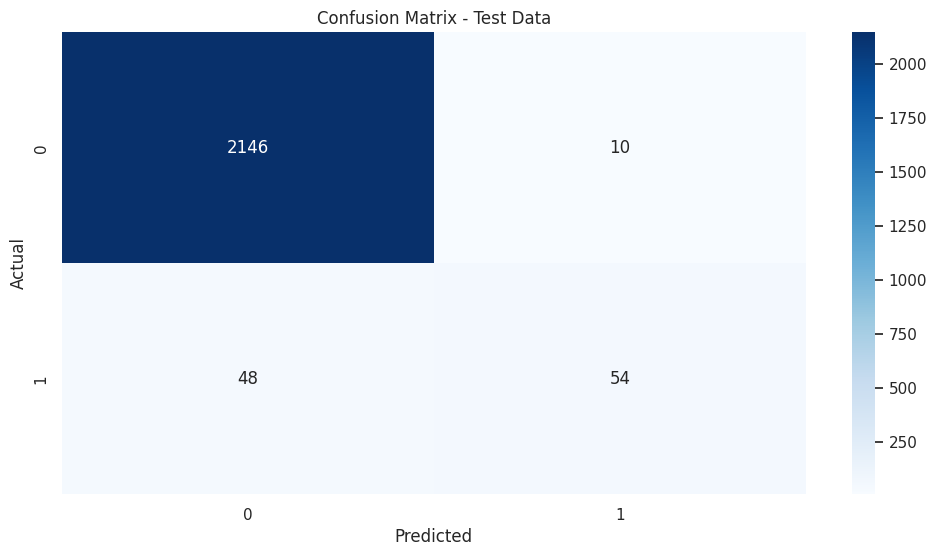

In [ ]:
y = [i.argmax() for i in actual_test_per_step['vanilla']]
pred = [i.argmax() for i in predictions_test_per_step['vanilla']]
cf_matrix_test = confusion_matrix(y, pred)
make_confusion_matrix_chart(cf_matrix_test)


In [ ]:
# Initialize lists to store precision, recall, and F1-score metrics for class 0, class 1, overall accuracy,
# macro average, and weighted average across multiple experiments
precision0 = []
precision1 = []
precisionacc = []
precisionmacavg = []
precisionweighavg = []
recall0 = []
recall1 = []
recallacc = []
recallmacavg = []
recallweighavg = []
f10 = []
f11 = []
f1acc = []
f1macavg = []
f1weighavg = []

# Loop through the results of multiple experiments
for i in range(No_exp):
    # Append precision, recall, and F1-score metrics for class 0, class 1, overall accuracy,
    # macro average, and weighted average from the model results
    precision0.append(metrics_test_per_step['vanilla'][i]['0']['precision'])
    precision1.append(metrics_test_per_step['vanilla'][i]['1']['precision'])
    precisionacc.append(metrics_test_per_step['vanilla'][i]['accuracy'])
    precisionmacavg.append(metrics_test_per_step['vanilla'][i]['macro avg']['precision'])
    precisionweighavg.append(metrics_test_per_step['vanilla'][i]['weighted avg']['precision'])

    recall0.append(metrics_test_per_step['vanilla'][i]['0']['recall'])
    recall1.append(metrics_test_per_step['vanilla'][i]['1']['recall'])
    recallacc.append(metrics_test_per_step['vanilla'][i]['accuracy'])
    recallmacavg.append(metrics_test_per_step['vanilla'][i]['macro avg']['recall'])
    recallweighavg.append(metrics_test_per_step['vanilla'][i]['weighted avg']['recall'])

    f10.append(metrics_test_per_step['vanilla'][i]['0']['f1-score'])
    f11.append(metrics_test_per_step['vanilla'][i]['1']['f1-score'])
    f1acc.append(metrics_test_per_step['vanilla'][i]['accuracy'])
    f1macavg.append(metrics_test_per_step['vanilla'][i]['macro avg']['f1-score'])
    f1weighavg.append(metrics_test_per_step['vanilla'][i]['weighted avg']['f1-score'])


In [ ]:
print(str(round(np.mean(precision0),4)) + "±" + str(round(np.std(precision0),4))," & " + str(round(np.mean(recall0),4)) + "±" + str(round(np.std(recall0),4)), " & " + str(round(np.mean(f10),4)) + "±" + str(round(np.std(f10),4)))
print(str(round(np.mean(precision1),4)) + "±" + str(round(np.std(precision1),4))," & " + str(round(np.mean(recall1),4)) + "±" + str(round(np.std(recall1),4)), " & " + str(round(np.mean(f11),4)) + "±" + str(round(np.std(f11),4)))
print(str(round(np.mean(precisionacc),4)) + "±" + str(round(np.std(precisionacc),4))," & " + str(round(np.mean(recallacc),4)) + "±" + str(round(np.std(recallacc),4)), " & " + str(round(np.mean(f1acc),4)) + "±" + str(round(np.std(f1acc),4)))
print(str(round(np.mean(precisionmacavg),4)) + "±" + str(round(np.std(precisionmacavg),4))," & " + str(round(np.mean(recallmacavg),4)) + "±" + str(round(np.std(recallmacavg),4)), " & " + str(round(np.mean(f1macavg),4)) + "±" + str(round(np.std(f1macavg),4)))
print(str(round(np.mean(precisionweighavg),4)) + "±" + str(round(np.std(precisionweighavg),4))," & " + str(round(np.mean(recallweighavg),4)) + "±" + str(round(np.std(recallweighavg),4)), " & " + str(round(np.mean(f1weighavg),4)) + "±" + str(round(np.std(f1weighavg),4)))


0.9781±0.0  & 0.9954±0.0  & 0.9867±0.0
0.8438±0.0  & 0.5294±0.0  & 0.6506±0.0
0.9743±0.0  & 0.9743±0.0  & 0.9743±0.0
0.9109±0.0  & 0.7624±0.0  & 0.8186±0.0
0.9721±0.0  & 0.9743±0.0  & 0.9715±0.0
